# Deep Generative Models: Variational Autoencoders
## Seminar in Artificial Intelligence
### Markus Böck

This work is based on [Pyro's excellent tutorials for deep generative models.](https://pyro.ai/examples).

In [1]:
%load_ext autoreload
%autoreload 2

## PyTorch

In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data

We consider two image data sets:

- MNIST: handwritten digits
- FashionMNIST: images of Zalando clothing articles

Both have 28 x 28 grayscale images with a 60000 train and 10000 test split.

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from utils import *

### MNIST

In [159]:
MNIST_train_data = datasets.MNIST(root='data', train=True,
                                  transform=ToTensor(),
                                  download=True)
MNIST_test_data = datasets.MNIST(root='data', train=False,
                                 transform=ToTensor())
len(MNIST_train_data), len(MNIST_test_data)

(60000, 10000)

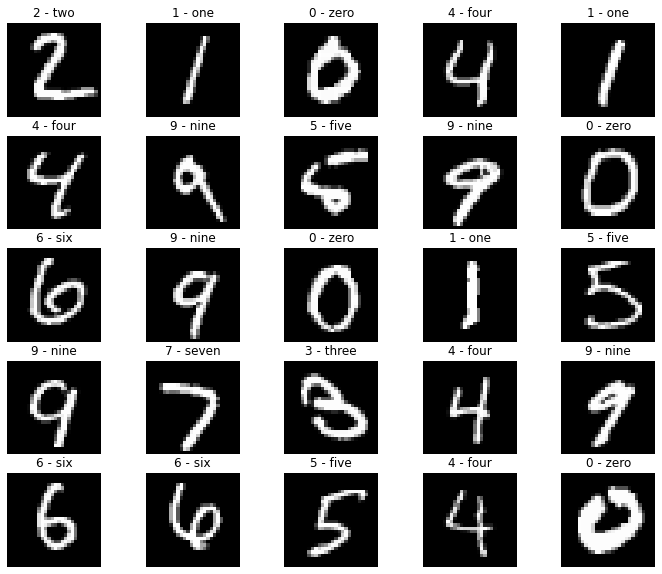

In [7]:
plot_batch_with_labels(MNIST_test_data, MNIST_test_data.classes)

### FashionMNIST

In [160]:
FashionMNIST_train_data = datasets.FashionMNIST(root='data', train=True,
                                                transform=ToTensor(),
                                                download=True)
FashionMNIST_test_data = datasets.FashionMNIST(root='data', train=False,
                                               transform=ToTensor())
len(FashionMNIST_train_data), len(FashionMNIST_test_data)

(60000, 10000)

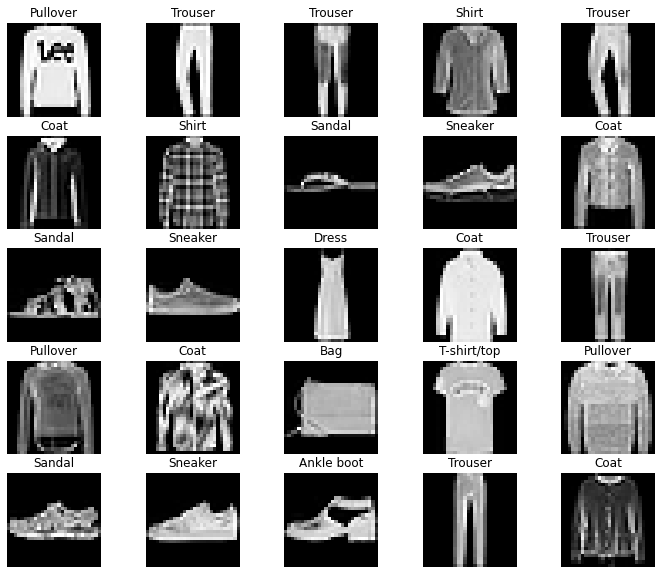

In [9]:
plot_batch_with_labels(FashionMNIST_test_data, FashionMNIST_test_data.classes)

Setup Dataloaders for PyTorch training loop.

We do not shuffle the data, because we designate the batches as supervised and unsupervised based on their ordering later.

Furthermore, we select 25 images for testing and visualisation purposes from each data set.

In [239]:
from torch.utils.data import DataLoader

MNIST_loaders = {
    'train' : DataLoader(MNIST_train_data, batch_size=256, shuffle=False, num_workers=4, pin_memory=True),
    'test'  : DataLoader(MNIST_test_data, batch_size=256, shuffle=False, num_workers=4, pin_memory=True),
}
MNIST_test_batch_x, MNIST_test_batch_y = get_batch(MNIST_test_data, 25, device)


FashionMNIST_loaders = {
    'train' : DataLoader(FashionMNIST_train_data, batch_size=256, shuffle=False, num_workers=4, pin_memory=True),
    'test'  : DataLoader(FashionMNIST_test_data, batch_size=256, shuffle=False, num_workers=4, pin_memory=True),
}
FashionMNIST_test_batch_x, FashionMNIST_test_batch_y = get_batch(FashionMNIST_test_data, 25, device)

## Goal

Learning the underlying distribution of the images $p(\mathbf{x})$ to be able to sample new images and predict image classes.

Here $\mathbf{x} \in [0,1]^{784}$ represents the grayscale values of an 28 x 28 input image.


## (Unsupervised) Variational Autoencoder - VAE

The basic idea of VAE is to model a latent space (which has much lower dimension then the feature/input space),
and use a neural network with weights $\theta$ as an *decoder* to define the joint distribution over input and laten variables $p_\theta(\mathbf{x}, \mathbf{z})$.

By selecting a prior over the latent space $p(\mathbf{z})$, we can write the joint distribution as 
$$p_\theta(\mathbf{x}, \mathbf{z}) = p_\theta(\mathbf{x}| \mathbf{z}) p(\mathbf{z})$$
and use marginalisation $$p_\theta(\mathbf{x}) = \int_\mathbf{z} p_\theta(\mathbf{x}| \mathbf{z}) p(\mathbf{z}) d\mathbf{z}$$ to obtain our parametrised distribution over the images $p_\theta(\mathbf{x})$.

We assume that the observed images are independent,
$$p_\theta(\mathbf{x}, \mathbf{z}) = \prod_{i=1}^N p_\theta(\mathbf{x}_i| \mathbf{z}_i) p(\mathbf{z}_i).$$
Thus, we have one latent variable for each data point.

We choose the prior $p(\mathbf{z})$ to be a simple Gaussian
$$p(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \mathbf{0}, \mathbf{I})$$
and also choose the likelihood $p_\theta(\mathbf{x}| \mathbf{z})$ to be independent Bernoulli variables, where the probability of a pixel being white comes from the decoder,
$$p_\theta(x_k = 1| \mathbf{z}) = \text{decoder}_\theta(\mathbf{z})_k, \quad k \in 1, \dots, 784.$$

A pixel having probability of 75% being white, can be interpreted as having a grayscale value of 0.75.
Note that the grayscale values of the pixels are independet of each other.

The reason to use a Bernoulli distribution here instead of the raw values of the decoder is to be able to condition on the observed images (the data set) in the Pyro model.

As usual in variational methods, we approximate the true posterior with Gaussians

$$p_\theta(\mathbf{z}| \mathbf{x}) \approx q_\phi(\mathbf{z}| \mathbf{x}) = \mathcal{N}(\mathbf{z}; \text{encoder_}\boldsymbol{\mu}_\phi(\mathbf{x}), \operatorname{diag}({\text{encoder_}\boldsymbol{\sigma}^2_\phi(\mathbf{x})})),$$
where we get the mean and standard deviation from the encoder - a neural network with weights $\phi$.

Instead of fitting the mean and standard deviation locally to each data point, we use a global encoder for that.
This is called amortization and allows us to handle large data sets.

Note that we again model the grayscale values of the pixels to be independent from each other.

In summary, we have an encoder mapping form image space to latent space, and an decoder mapping from latent space to image space:
![](figs/VAE_Basic.png)


Source: https://en.wikipedia.org/wiki/Variational_autoencoder

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

Overview of activation functions:

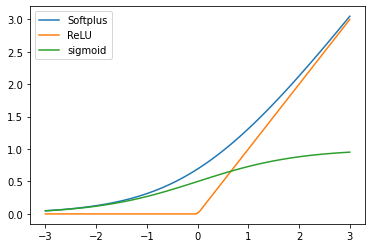

In [172]:
softplus = nn.Softplus()
ts = torch.tensor(np.linspace(-3,3,100))
plt.plot(ts, softplus(ts), label='Softplus')
relu = nn.ReLU()
plt.plot(ts, relu(ts), label='ReLU')
plt.plot(ts, torch.sigmoid(ts), label='sigmoid')
plt.legend()
plt.show()

The decoder consists of three fully connected layers.

The input has the dimension of the latent space and the output is 784 dimensional (28 x 28 grayscale image).

The las tactivation is the sigmoid to get values in $[0,1]$ - the probabilities of pixels being white.

In [51]:
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[1])
        self.fc2 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], output_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, z):
        z = self.softplus(self.fc1(z))
        z = self.softplus(self.fc2(z))
        loc_img = torch.sigmoid(self.fc3(z)) # probabilities of pixels being white
        return loc_img

The encoder consits of two fully connected layers and has two heads - one for the mean and one for the standard deviation.

The input is 784 dimensional (28 x 28 grayscale image) and the output has the dimension of the latent space (two times).


In [50]:
# diagonal gaussian distribution q(z|x)
class EncoderZ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        
        # two heads for mean and std
        self.fc31 = nn.Linear(hidden_dims[1], output_dim)
        self.fc32 = nn.Linear(hidden_dims[1], output_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.softplus(self.fc1(x))
        x = self.softplus(self.fc2(x))
        
        z_loc = self.fc31(x)
        z_scale = torch.exp(self.fc32(x))
        return z_loc, z_scale

Putting the model together as described in the VAE introduction.

The encoder plays the role of the guide and the model is based on the decoder.

The job of the guide is to "guess" good values for the latent random variables in the sense that they are true to the model prior and true to the data.

In [233]:
class VAE(nn.Module):
    def __init__(self, z_dim, hidden_dims, device, input_size=784):
        super().__init__()
        self.input_size = input_size
        self.z_dim = z_dim
        
        self.encoder = EncoderZ(input_size, z_dim, hidden_dims)
        self.decoder = Decoder(z_dim, input_size, hidden_dims)
        
        self.to(device)

    # define the model p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            
            # sample from prior p(z)
            # to_event(1) ... treat variables being generated from a multivariate normal
            # distribution with diagonal covariance instead of as being generated from a univariate normal
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # sample from p(x|z)
            loc_img = self.decoder.forward(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                obs=x, 
            )
            # we disable validate_args as we compare a boolean sample to a continuous [0,1] input x
            # -> continuous (relaxed) bernoulli variable with pdf lambda^x (1-lambda)^(1-x) x in [0,1]
            
            return loc_img

    # define the guide (variational distribution) q(z|x)
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            
            # sample the latent variable z from q(z|x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

### Optimization with Stochastic Variational Inference - SVI

The goal is to maximise the probability of observing our data (*evidence*)
$$\log p_\theta(\mathbf{x})$$
with respect to the parameters $\theta$.

Direct optimization of our model
$$p_\theta(\mathbf{x}) = \int_\mathbf{z} p_\theta(\mathbf{x}, \mathbf{z}) d\mathbf{z} = \int_\mathbf{z} p_\theta(\mathbf{x}| \mathbf{z}) p(\mathbf{z}) d\mathbf{z}$$
is intractable.

Instead we make use of our variational distribution - the guide - and observe that
$$\log p_\theta(\mathbf{x}) \ge \log p_\theta(\mathbf{x}) - D_{KL}(q_\phi(\mathbf{z}| \mathbf{x}) || p_\theta(\mathbf{x}| \mathbf{z})) = \mathbb{E}_{\mathbf{z} \sim q_\phi(.| \mathbf{x})}\left[\log   p_\theta(\mathbf{x}, \mathbf{z}) - \log q_\phi(\mathbf{z} | \mathbf{x})  \right] =: \text{ELBO}_{\theta, \phi}.$$

Thus, by maximising the so called Evidence-Lower-Bound jointly in $\theta$ and $\phi$, we not only minimise the Kullback-Leibler divergence between posteriour and guide
$$D_{KL}(q_\phi(\mathbf{z}| \mathbf{x}) || p_\theta(\mathbf{x}| \mathbf{z})),$$
but also maximise a lower bound to the model evidence $\log p_\theta(\mathbf{x})$.

To do so we only need two assumptions:

- We need to be able to sample from the guide $\mathbf{z} \sim q_\phi(.| \mathbf{x})$ to get Monte Carlo estimates of the ELBO.
- We need to be able to compute and differantiate the log probabilites with respect to the parameters.

Sources:

- https://pyro.ai/examples/svi_part_i.html
- https://en.wikipedia.org/wiki/Evidence_lower_bound

The corresponding code looks like standard gradient optimization:

In [234]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

def train_VAE(loaders, vae, device, epochs=25, verbose=True, show_plot=True):
    optimizer = Adam({'lr': 1.0e-3})

    elbo = Trace_ELBO()
    svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

    train_elbo = []
    test_elbo = []
    
    for epoch in range(1, epochs+1):
        
        # perform svi steps on train loader
        epoch_loss = 0.0
        for x, _ in loaders['train']:
            x = x.reshape(-1, vae.input_size).to(device)
            epoch_loss += svi.step(x)

        total_epoch_loss_train = epoch_loss / len(loaders['train'].dataset)
        train_elbo.append(total_epoch_loss_train)

        # evaluate loss on test loader
        test_loss = 0.0
        for x, _ in loaders['test']:
            x = x.reshape(-1, vae.input_size).to(device)
            test_loss += svi.evaluate_loss(x)

        total_epoch_loss_test = test_loss / len(loaders['test'].dataset)
        test_elbo.append(total_epoch_loss_test)
        
        if verbose:
            print(f"Epoch {epoch:4d}: training loss: {total_epoch_loss_train:.4f} test loss: {total_epoch_loss_test:.4f}", end='\r')
    
    # plot losses
    if show_plot:
        plt.plot(train_elbo, label='ELBO train')
        plt.plot(test_elbo, label='ELBO test')
        plt.xlabel('Epoch')
        plt.ylabel('ELBO')
        plt.legend()
        plt.show()

### MNIST

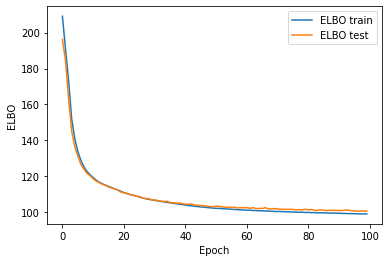

Wall time: 14min 14s


In [235]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x
test_batch_y = MNIST_test_batch_y

vae = VAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_VAE(loaders, vae, epochs=100, device=device)

Now that we have fit the model we can test its reconstruction capabilities by feeding a image to the encoder, sampling in latent space, and reconstructing the image with the decoder:

In [236]:
def vae_reconstruct_imgs(vae, x):
    z_loc, z_scale = vae.encoder(x.reshape(-1, vae.input_size))
    z = dist.Normal(z_loc, z_scale).sample() # sample in latent space
    loc_img = vae.decoder(z) # return probabilities of Bernoulli variables p(x|z) as grayscale value
    return loc_img

Original Batch


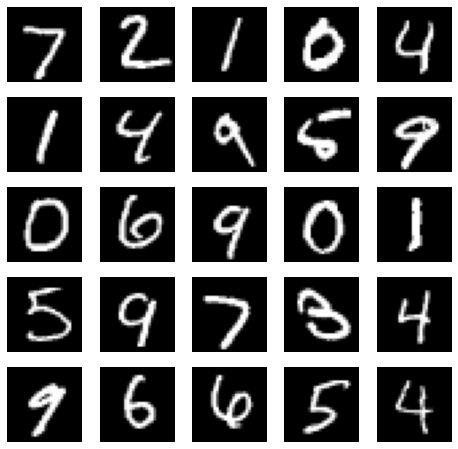

Reconstructed Batch


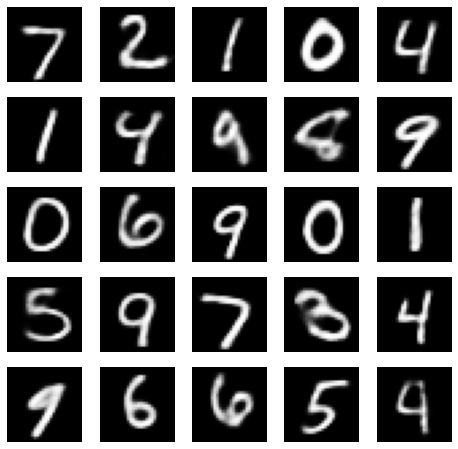

In [242]:
print('Original Batch')
plot_batch(test_batch_x.cpu().reshape((25, 1, 28, 28)),figsize=(8, 8))

print('Reconstructed Batch')
reconstruced_x = vae_reconstruct_imgs(vae, test_batch_x)
plot_batch(reconstruced_x.cpu().detach().numpy().reshape((25, 1, 28, 28)), figsize=(8, 8))

The results look like fuzzy versions of the input.

We can also directly sample in latent space from our prior and then decode the latent variable to get new images.

In [243]:
def vae_sample_imgs(vae, n, device):
    z_loc = torch.zeros(n, vae.z_dim, device=device)
    z_scale = torch.ones(n, vae.z_dim, device=device)
    
    z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1)) # sample from prior p(z)
    imgs = vae.decoder.forward(z) # return probabilities of Bernoulli variables p(x|z) as grayscale value
    return imgs

Sampled images


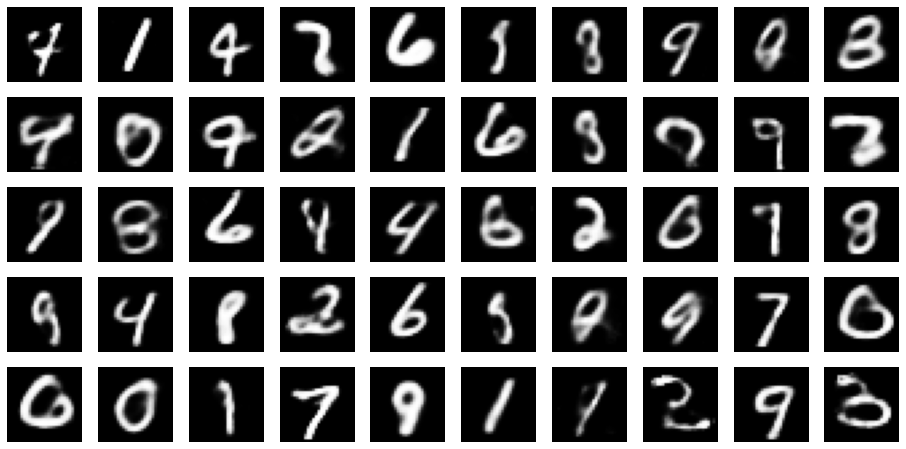

In [244]:
print('Sampled images')
N = 50
sampled_x = vae_sample_imgs(vae, N, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

New images don't look that impressive.

### MNIST with low dimensional latent space

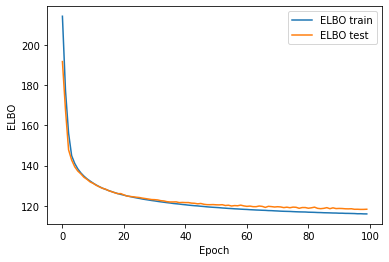

Original Batch


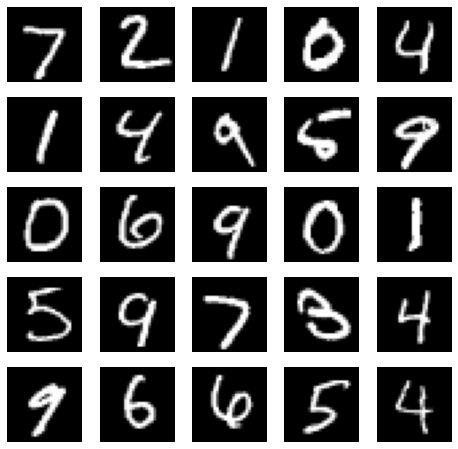

Reconstructed Batch


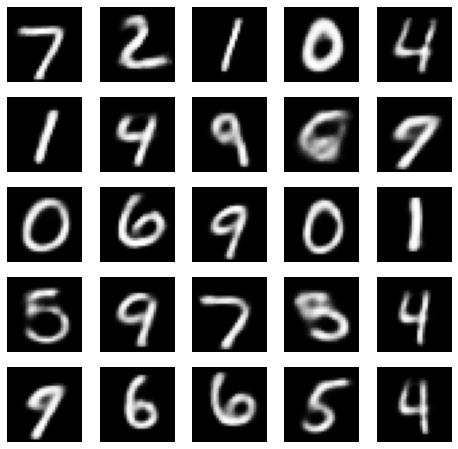

Sampled images


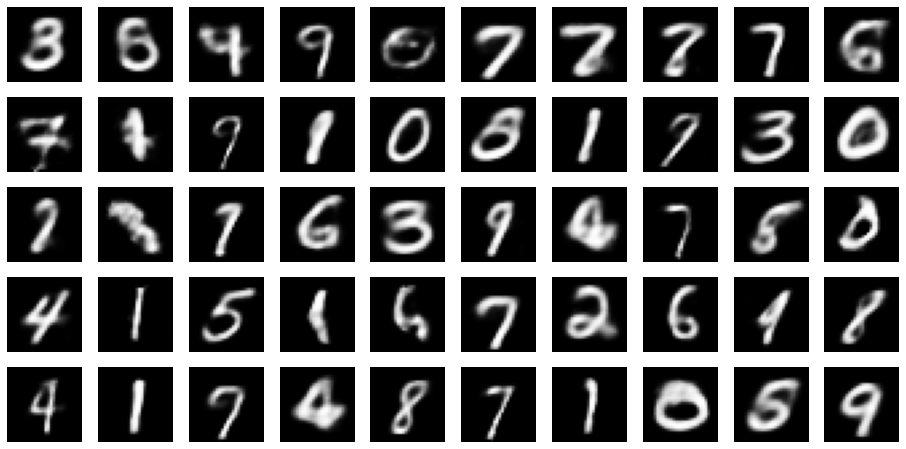

Wall time: 14min 43s


In [245]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x
test_batch_y = MNIST_test_batch_y

vae = VAE(z_dim=2, hidden_dims=[100, 300], device=device)
train_VAE(loaders, vae, epochs=100, device=device)

print('Original Batch')
plot_batch(test_batch_x.cpu().reshape((25, 1, 28, 28)),figsize=(8, 8))

print('Reconstructed Batch')
reconstruced_x = vae_reconstruct_imgs(vae, test_batch_x)
plot_batch(reconstruced_x.cpu().detach().numpy().reshape((25, 1, 28, 28)), figsize=(8, 8))

print('Sampled images')
N = 50
sampled_x = vae_sample_imgs(vae, N, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

Looks almost like before, maybe less variation.

### FashionMNIST

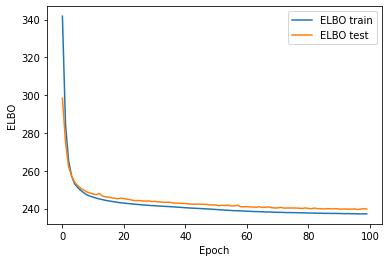

Original Batch


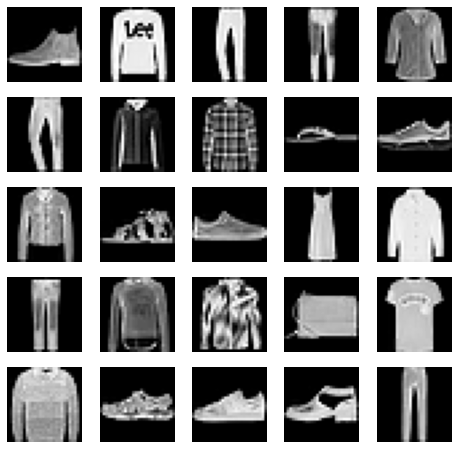

Reconstructed Batch


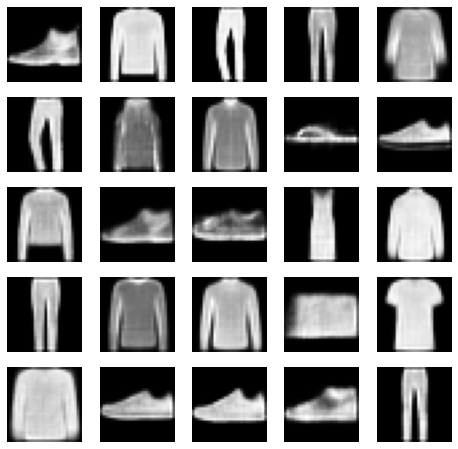

Sampled images


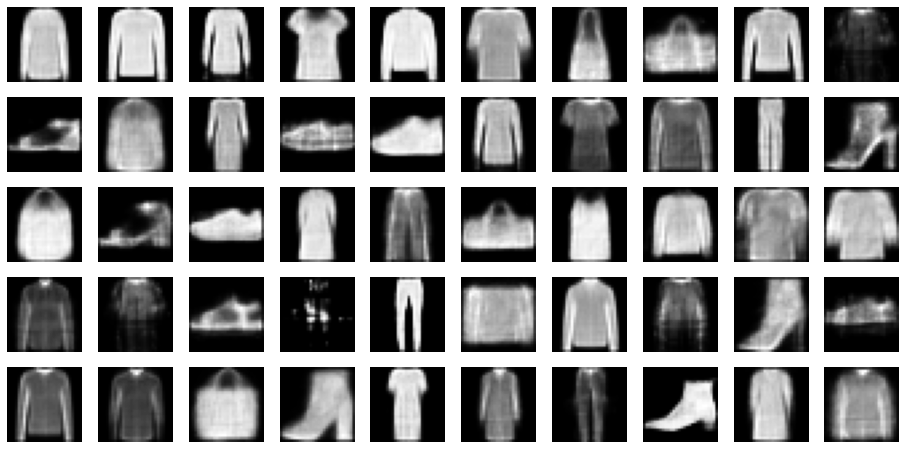

Wall time: 14min 51s


In [247]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = FashionMNIST_loaders
test_batch_x = FashionMNIST_test_batch_x
test_batch_y = FashionMNIST_test_batch_y

vae = VAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_VAE(loaders, vae, epochs=100, device=device)

print('Original Batch')
plot_batch(test_batch_x.cpu().reshape((25, 1, 28, 28)),figsize=(8, 8))

print('Reconstructed Batch')
reconstruced_x = vae_reconstruct_imgs(vae, test_batch_x)
plot_batch(reconstruced_x.cpu().detach().numpy().reshape((25, 1, 28, 28)), figsize=(8, 8))

print('Sampled images')
N = 50
sampled_x = vae_sample_imgs(vae, N, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

The images loose a lot of detail.

## (Semi-)Supervised Variational Autoencoder

Until now we haven't used the true class labels $\mathbf{y}$.
We extend the VAE to leverage this information by updating the model to
$$p_\theta(\mathbf{x}, \mathbf{y}, \mathbf{z}) = p_\theta(\mathbf{x} |\mathbf{y}, \mathbf{z}) p(\mathbf{y}) p(\mathbf{z}).$$

First, we introduce a prior over $\mathbf{y}$, a categorical distribution with equal weights for all classes,
$$p(\mathbf{y}=i) = \frac{1}{\text{#classes}}.$$

The prior over $\mathbf{z}$ remains the same Gaussian $\mathcal{N}(\mathbf{z}; \mathbf{0}, \mathbf{I})$.

The decoder now depends on the latent variable $\mathbf{z}$ and the label $\mathbf{y}$,
$$p_\theta(x_k = 1| \mathbf{z}) = \text{decoder}_\theta(\mathbf{y}, \mathbf{z})_k, \quad k \in 1, \dots, 784.$$

Furthermore, we introduce an encoder for $\mathbf{y}$, which returns the class probabilites fed into a categorical distribution solely dependet on the image $\mathbf{x}$,
$$q_\phi(\mathbf{y}|\mathbf{x}) = \text{Categorical}(\mathbf{y}; \text{encoder_}\mathbf{y}(\mathbf{z}) ).$$

The encoder for the mean and standard deviation of $\mathbf{z}$ now also depends on the class,
$$q_\phi(\mathbf{z}| \mathbf{x}, \mathbf{y}) = \mathcal{N}(\mathbf{z}; \text{encoder_}\boldsymbol{\mu}_\phi(\mathbf{x}, \mathbf{y}), \operatorname{diag}({\text{encoder_}\boldsymbol{\sigma}^2_\phi(\mathbf{x}, \mathbf{y})})),$$
to get the full guide
$$q_\phi(\mathbf{z}| \mathbf{x}) = q_\phi(\mathbf{z}| \mathbf{x}, \mathbf{y}) q_\phi(\mathbf{y}|\mathbf{x}).$$


The encoder for $\mathbf{y}$ is a simple three layer network, where the last activation is softmax to get class probabilites.

It maps from image input the labels.

In [95]:
class EncoderY(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)
        
        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):        
        x = self.softplus(self.fc1(x))
        x = self.softplus(self.fc2(x))
        
        y = self.softmax(self.fc3(x)) # returns class probabilities
        return y

The dependence of the encoder for $\mathbf{z}$ on $\mathbf{y}$ is achieved by simply concatinating $\mathbf{x}$ and $\mathbf{y}$.

$\mathbf{y}$ is always one-hot encoded.

The model and guide now depend on $\mathbf{x}$ and $\mathbf{y}$.

But we can also omit the label $\mathbf{y}$.

The guide then samples from $p(\mathbf{y})$ as described above.

This allows a **semi-supervised approach**.

We also define an *auxiliary* model which is just concerned about the correct classification of the encoder for $\mathbf{y}$.

This helps convergence and improves the accuracy.


In [129]:
class SSVAE(nn.Module):
    def __init__(self, z_dim, hidden_dims,  device, input_size=784, n_labels=10, aux_loss_multiplier=50):
        super().__init__()
        
        self.z_dim = z_dim
        self.input_size = input_size
        self.output_size = n_labels
        
        self.concat = ConcatModule(allow_broadcast=True)
        self.encoder_z = EncoderZ(input_size + n_labels, z_dim, hidden_dims)
        self.encoder_y = EncoderY(input_size, n_labels, hidden_dims)
        
        self.decoder = Decoder(z_dim + n_labels, input_size, hidden_dims)
        
        self.aux_loss_multiplier = aux_loss_multiplier
        
        self.to(device)

    # define the model p(x|y,z) p(y) p(z)
    def model(self, x, y=None):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            
            # sample from prior p(z)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # setup hyperparameters for prior p(y)
            alpha = torch.ones(x.shape[0], self.output_size, dtype=x.dtype, device=x.device) / (1.0 * self.output_size)
            
            # sample from prior p(y)
            y = pyro.sample("y", dist.OneHotCategorical(alpha), obs=y)
            
            # sample from p(x|y,z)
            loc_img = self.decoder.forward(self.concat.forward(z, y))
            
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                obs=x,
            )
            
            return loc_img

    # define the guide (variational distribution) q(z|x,y) q(y|x)
    def guide(self, x, y=None):
        pyro.module("encoder_z", self.encoder_z)
        pyro.module("encoder_y", self.encoder_y)
        with pyro.plate("data", x.shape[0]):
            if y is None:
                # use the encoder to get the parameters used to define q(y|x)
                alpha = self.encoder_y.forward(x)
                # sample q(y|x)
                y = pyro.sample("y", dist.OneHotCategorical(alpha))
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_z.forward(self.concat.forward(x, y))

            # sample q(z|x,y)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
           
        
    # auxiliary model
    def model_classify(self, x, y):
        pyro.module("encoder_y", self.encoder_y)
        assert y is not None
        with pyro.plate("data"):
            alpha = self.encoder_y.forward(x)
            with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=y)
                
    def guide_classify(self, x, y=None):
        pass

We can make classifications based on the encoder for $\mathbf{y}$ by predicting the class with highest probability.

In [130]:
def ssvae_classify(ssvae, x):
    alpha = ssvae.encoder_y.forward(x)
    _, label = torch.topk(alpha, 1) # argmax
    y = F.one_hot(label.reshape(-1), ssvae.output_size)
    return y

The training loop for the semi-supervised VAE changes a bit.

We use enumeration `TraceEnumELBO`.
This means that the Monte Carlo expectation over the discrete $\mathbf{y}$,
$$\mathbb{E}_{\mathbf{y}\sim q_\phi(.|\mathbf{x})}\left[\nabla \text{ELBO} \right]$$
is replaced with an explicit sum
$$\sum_{\mathbf{y}} q_\phi(\mathbf{y}|\mathbf{x})\nabla \text{ELBO}$$
which helps decrease variance in the gradient estimate.

Furthermore, we add the parameter `nth_supervised`.
If it equals $n$ then only every $n$-th batch is supervised.

We can also toggle the auxiliary model with `aux_loss`.

In [249]:
from pyro.infer import TraceEnum_ELBO, config_enumerate

def train_SSVAE(loaders, ssvae, device,
                nth_supervised=None, aux_loss=False, epochs=25,
                verbose=True, show_plot=True):
    
    optimizer = Adam({'lr': 0.0005})

    # summing out discrite y by enumeration
    guide = config_enumerate(ssvae.guide, 'parallel', expand=True)
    elbo = TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False)
    
    svi = SVI(ssvae.model, guide, optimizer, loss=elbo)
    
    # auxiliary model
    elbo_aux = Trace_ELBO()
    svi_aux = SVI(ssvae.model_classify, ssvae.guide_classify, optimizer, loss=elbo_aux)
    
    train_elbo = []
    test_elbo = []
    test_acc = []
    
    if nth_supervised:
        N = len(loaders['train'])
        print(f'Number of supervised batches: {N//nth_supervised}/{N}')
    
    for epoch in range(1, epochs+1):
        
        # perform svi steps on train loader
        epoch_loss = 0.0
        n_sup = 0
        n_unsup = 0
        for i, (x, y) in enumerate(loaders['train']):
            x = x.reshape(-1, ssvae.input_size).to(device)
            
            # alternate between supervised and unsupervised batches
            if nth_supervised and (i % nth_supervised == 0): # batches are not shuffled
                y = F.one_hot(y, ssvae.output_size).to(device)
                
                # perform step on auxiliary model
                if aux_loss:
                    epoch_loss += svi_aux.step(x, y)
                    
                n_sup += x.shape[0]
            else:
                y = None
                n_unsup += x.shape[0]
                
            epoch_loss += svi.step(x, y)

        total_epoch_loss_train = epoch_loss / len(loaders['train'].dataset)
        train_elbo.append(total_epoch_loss_train)

        # evaluate loss and accuracy on test loader
        test_loss = 0.0
        y_correct = 0
        for x, y in loaders['test']:
            x = x.reshape(-1, ssvae.input_size).to(device)
            y = F.one_hot(y, ssvae.output_size).to(device)
            
            test_loss += svi.evaluate_loss(x, y)
            if aux_loss:
                test_loss += svi_aux.evaluate_loss(x, y)

            y_correct += (ssvae_classify(ssvae, x) == y).all(dim=1).sum()
                
        total_epoch_loss_test = test_loss / len(loaders['test'].dataset)
        test_elbo.append(total_epoch_loss_test)
        
        total_epoch_acc_test = y_correct.cpu().detach().numpy() / len(loaders['test'].dataset)
        test_acc.append(total_epoch_acc_test)
        
        if verbose:
            print(f"Epoch {epoch:4d}: training loss: {total_epoch_loss_train:.4f} test loss: {total_epoch_loss_test:.4f} test acc: {total_epoch_acc_test:.4f} ({n_sup=} {n_unsup=})", end='\r')
    
    # plot losses and accuracy
    if show_plot:
        plt.plot(train_elbo, label='ELBO train')
        plt.plot(test_elbo, label='ELBO test')
        plt.xlabel('Epoch')
        plt.ylabel('ELBO')
        plt.legend()
        plt.show()
        
        plt.plot(test_acc, label='Test accuracy', color='tab:green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


### MNIST

In [256]:
loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x.reshape(-1, ssvae.input_size)
test_batch_y = F.one_hot(MNIST_test_batch_y, ssvae.output_size)

In [252]:
%%time
seed_everything()
pyro.clear_param_store()

ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)

loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x.reshape(-1, ssvae.input_size)
test_batch_y = F.one_hot(MNIST_test_batch_y, ssvae.output_size)

train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=1)

Number of supervised batches: 23/235


KeyboardInterrupt: 

Does not work without auxiliary model.

Number of supervised batches: 235/235


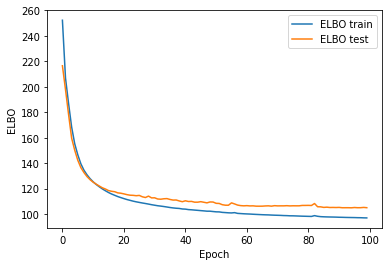

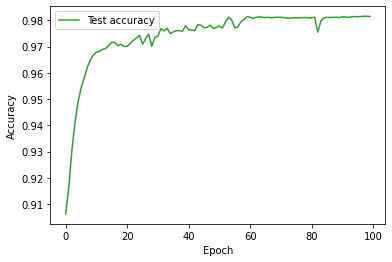

Wall time: 17min 31s


In [257]:
%%time
seed_everything()
pyro.clear_param_store()

ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=1, aux_loss=True)

Works really well now!

#### Only every 10th batch supervised.

Number of supervised batches: 117/235


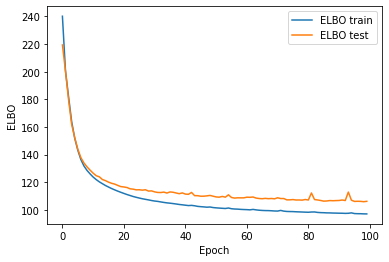

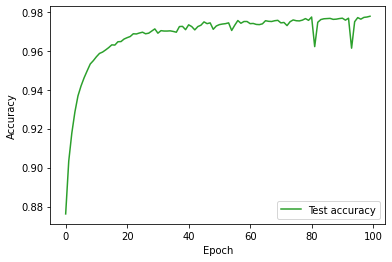

Wall time: 20min 18s


In [153]:
%%time
seed_everything()
pyro.clear_param_store()

ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=10, aux_loss=True)

Almost the same perfomance with only 1/10 the of the labels!

Again we can reconstruct and sample images.
Now with the difference that we can choose the class that we want to sample from.

In [258]:
def ssvae_reconstruct_imgs(ssvae, x, y):
    z_loc, z_scale = ssvae.encoder_z(ssvae.concat(x, y))
    z = dist.Normal(z_loc, z_scale).sample() # sample in latent space
    loc_img = ssvae.decoder(ssvae.concat(z, y))
    return loc_img

In [259]:
def ssvae_sample_imgs(ssvae, n, y, device):
    y = F.one_hot(y, ssvae.output_size)

    z_loc = torch.zeros(n, ssvae.z_dim, device=device)
    z_scale = torch.ones(n, ssvae.z_dim, device=device)
    
    z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    imgs = ssvae.decoder(ssvae.concat(z, y))
    return imgs

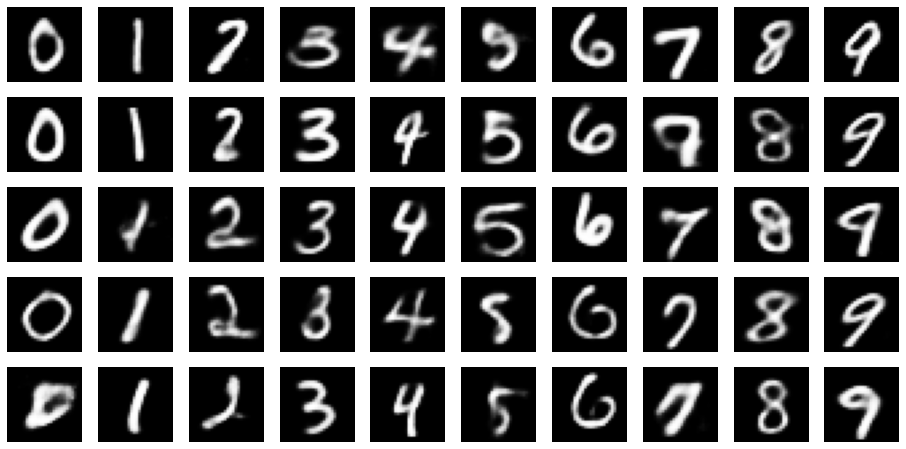

In [260]:
N = 50
selected_y = torch.tensor([i % 10 for i in range(50)]).to(device)
sampled_x = ssvae_sample_imgs(ssvae, N, selected_y, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

Good sampling now!

#### Completely unsuperivsed

In [ ]:
%%time
seed_everything()
pyro.clear_param_store()

ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=None)

N = 50
selected_y = torch.tensor([i % 10 for i in range(50)]).to(device)
sampled_x = ssvae_sample_imgs(ssvae, N, selected_y, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

Does not correctly learn labels.

### FashionMNIST

In [ ]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = FashionMNIST_loaders
test_batch_x = FashionMNIST_test_batch_x
test_batch_y = FashionMNIST_test_batch_y

ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=10, aux_loss=True)

N = 50
selected_y = torch.tensor([i % 10 for i in range(50)]).to(device)
sampled_x = ssvae_sample_imgs(ssvae, N, selected_y, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

Number of supervised batches: 23/235
